### Importação das Bibliotecas

In [13]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Ciência de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Biblioteca do Prophet - Modelo de Projeção
from prophet import Prophet
from prophet.plot import plot, plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot, plot_seasonality, plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### Importação e Descrição dos Dados

Essa é a parte 3 de um projeto que busca prever as vendas de uma padaria francesa, agora através de modelos de Deep Learning.

Para uma melhor compreensão do cenário, caso ainda não tenha acompanhado, recomenda-se ler o notebook ```bakery_sales_data_analysis.ipynb``` que apresenta uma analise exploratória do dados e o notebook ```bakery_sales_forecasting.ipynb``` traz previsões de vendas com modelos de regressão de Machine Learning.

In [14]:
df = pd.read_csv('bakery_sales.csv', index_col=0)

# Update datatypes and data processing
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

df['Quantity'] = df['Quantity'].apply(lambda x: abs(int(x)))
df['Quantity'] = df['Quantity'].astype(int)

df['unit_price'] = df['unit_price'].str[:-2]
df['unit_price'] = df['unit_price'].str.replace(",",".")
df['unit_price'] = df['unit_price'].astype(float)

df['ticket_number'] = df['ticket_number'].astype(int)

# Cria coluna do total da compra
df['total_bill'] = df['Quantity'] * df['unit_price']

# Como nesse momento não será feita uma análise por produto, a coluna sera dropada
df.rename(columns={'Quantity':'quantity'}, inplace=True)
df_backup = df.copy()
df.drop(columns=['article', 'unit_price'], inplace=True)
df.head()

,date,time,ticket_number,quantity,total_bill
0,2021-01-02,08:38:00,150040,1,0.90
1,2021-01-02,08:38:00,150040,3,3.60
4,2021-01-02,09:14:00,150041,2,2.40
5,2021-01-02,09:14:00,150041,1,1.15
8,2021-01-02,09:25:00,150042,5,6.00


In [15]:
# Agrupa os dados por ticket (nota fiscal)
df_grouped = df.groupby(by=('ticket_number')).agg({'date':'first',
                                                   'time':'first',
                                                   'quantity':'sum',
                                                   'total_bill':'sum'})

df_grouped.reset_index(inplace=True)

df_grouped.head()

,ticket_number,date,time,quantity,total_bill
0,150040,2021-01-02,08:38:00,4,4.50
1,150041,2021-01-02,09:14:00,3,3.55
2,150042,2021-01-02,09:25:00,5,6.00
3,150043,2021-01-02,09:25:00,5,5.10
4,150044,2021-01-02,09:27:00,1,1.05


In [16]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136451 entries, 0 to 136450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ticket_number  136451 non-null  int32         
 1   date           136451 non-null  datetime64[ns]
 2   time           136451 non-null  object        
 3   quantity       136451 non-null  int32         
 4   total_bill     136451 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ MB


#### Novas Features

In [17]:
# Novas Variaves, para analise
df = df_grouped.copy()

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_week'] = df.date.dt.day_of_week
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Cria um dataset com dados diarios
df_daily = df_grouped[['date', 'quantity', 'total_bill']].groupby('date').sum().reset_index()

df_daily['year'] = df_daily.date.dt.year
df_daily['month'] = df_daily.date.dt.month
df_daily['day'] = df_daily.date.dt.day
df_daily['day_week'] = df_daily.date.dt.day_of_week
df_daily['day_of_year'] = df_daily.date.dt.dayofyear

df_daily.rename(columns={'total_bill':'sales'}, inplace=True)
df_daily.head()

,date,quantity,sales,year,month,day,day_week,day_of_year
0,2021-01-02,581,987.85,2021,1,2,5,2
1,2021-01-03,566,1016.10,2021,1,3,6,3
2,2021-01-04,315,461.90,2021,1,4,0,4
3,2021-01-05,315,536.50,2021,1,5,1,5
4,2021-01-07,310,544.00,2021,1,7,3,7


In [18]:
df_daily.shape

(600, 8)

## Previsão com Deep Learning

### Organizando os dados

⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️ Inserir descrição

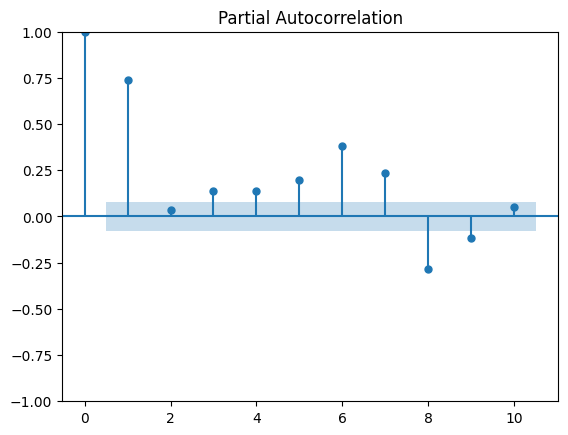

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

# Determinando quantas lags utilizar
plot_pacf(df_daily['sales'], lags=10)
plt.show()

In [129]:
data = df_daily[['date', 'sales']].copy()
data['lag_1'] = data['sales'].shift(1)
data.head()

,date,sales,lag_1
0,2021-01-02,987.85,NaN
1,2021-01-03,1016.10,987.85
2,2021-01-04,461.90,1016.10
3,2021-01-05,536.50,461.90
4,2021-01-07,544.00,536.50


In [41]:
date_plot = data.loc[1:,'date']
X_data = data.loc[1:,'sales']
y_data = data.loc[1:,'lag_1']

# Separa os dados em treino e teste
# utiliza os últimos 'day_to_test' dias de teste
day_to_test = 40
X_train = X_data[:-day_to_test]
y_train = y_data[:-day_to_test]

X_test = X_data[-day_to_test:]
y_test = y_data[-day_to_test:]


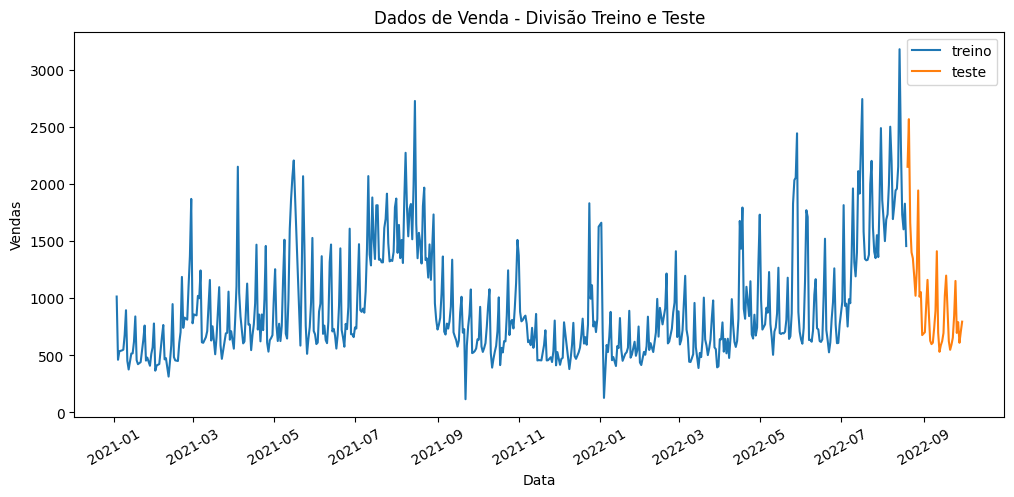

In [50]:
plt.figure(figsize=(12,5))
sns.lineplot(data=data[1:-day_to_test], x='date', y='sales', label='treino')
sns.lineplot(data=data[-day_to_test:], x='date', y='sales', label='teste')
plt.title('Dados de Venda - Divisão Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.xticks(rotation=30)
plt.show()

#### Dados scaled

In [57]:
# Cria scaler com fit apenas nos dados de treino
scaler = StandardScaler()
scaler.fit(X_train.values.reshape(-1,1))

# Aplica transform em todos os dados
X_train_sc = scaler.transform(X_train.values.reshape(-1,1))
y_train_sc = scaler.transform(y_train.values.reshape(-1,1))
X_test_sc = scaler.transform(X_test.values.reshape(-1,1))
y_test_sc = scaler.transform(y_test.values.reshape(-1,1))

In [77]:
X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

### Criando o modelo

In [83]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense

#### RNN - Rede Neural Recorrente

In [89]:
# Define os parametros do modelo
model = Sequential()

model.add(LSTM(128, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [92]:
# model.summary()

In [95]:
resultado = model.fit(X_train_sc, y_train_sc, validation_data=(X_test_sc, y_test_sc), epochs=100)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7975 - val_loss: 0.6943
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6933 - val_loss: 0.6098
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5867 - val_loss: 0.5452
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5533 - val_loss: 0.4993
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4667 - val_loss: 0.4797
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4148 - val_loss: 0.4812
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5209 - val_loss: 0.4829
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4322 - val_loss: 0.4844
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5023 - val_loss: 0.4851
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3915 - val_loss: 0.4819
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4390 - val_loss: 0.4837
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [121]:
y_pred_train = model.predict(X_train_sc)
y_pred_test = model.predict(X_test_sc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[]

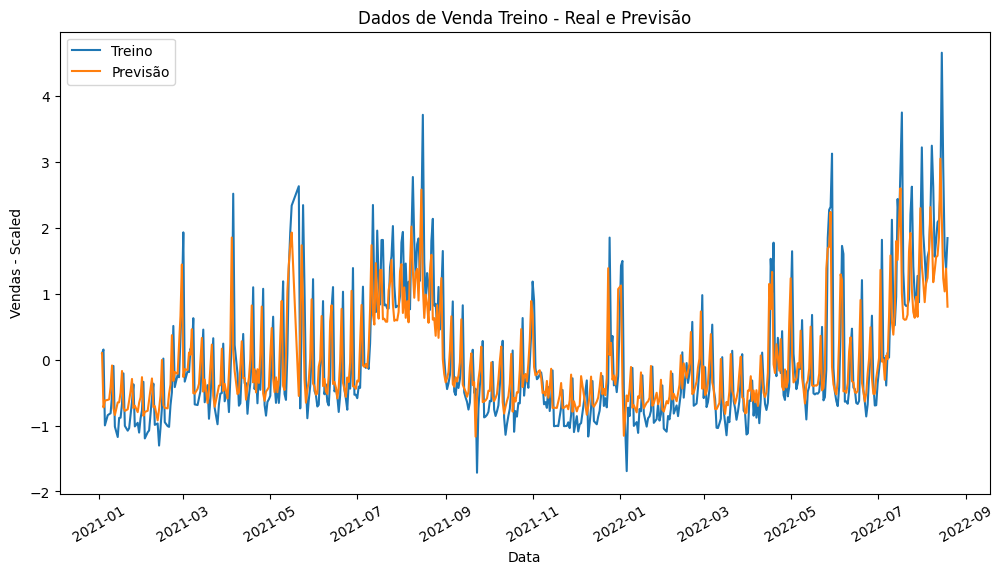

In [127]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_train_sc[:,0], label='Treino')
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_pred_train[:,0], label='Previsão')
plt.title('Dados de Venda Treino - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

In [122]:
df_daily[-day_to_test:].shape, len(y_test_sc[:,0]), len(y_pred_test[:,0])

((40, 8), 40, 40)

[]

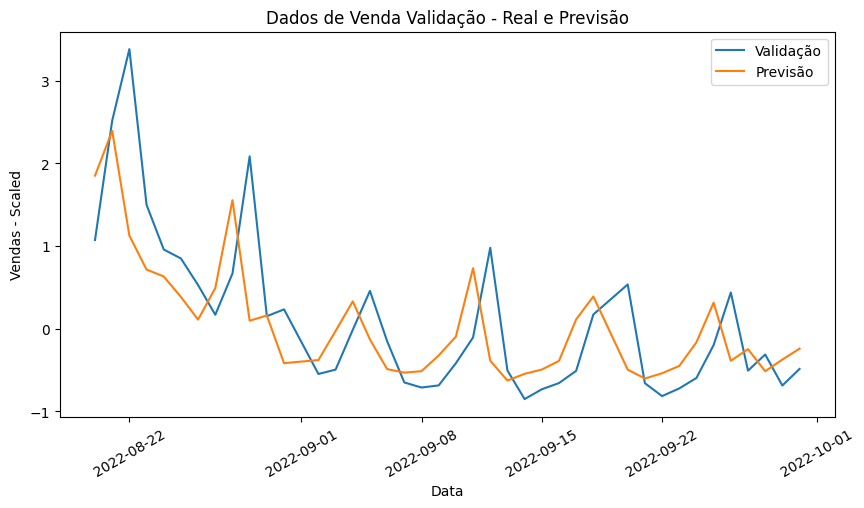

In [124]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_test_sc[:,0], label='Validação')
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_pred_test[:,0], label='Previsão')
plt.title('Dados de Venda Validação - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()